In [18]:
import pandas as pd
import numpy as np
%matplotlib inline

# Using Python Modules

Last week I had the following code in my notebook for the lecture to read in an XML file to a data frame.  Having this code inline like this is good for my lectures since I want to show you the code, but in general it looks messy. 

It's also a potentially re-usable bit of code that I might want to use in other notebooks or later on in this same notebook to read an XML file.  

A better option is to use a separate Python file that we import into this notebook, and to write the code as a function in that file that we can use here.  

Let's refactor this code to do this...

In [ ]:
# here is the original code block
import xml.etree.ElementTree as ET

tree = ET.parse('files/sample.xml')
root = tree.getroot()
data = []
for row in root:
    # create a dictionary for each row
    datarow = {}
    for child in row:
        # dictionary key is the tag name, value is the text in the tag
        datarow[child.tag] = child.text
    data.append(datarow)

# now make a dataframe from this list of dictionaries
df = pd.DataFrame(data)
# sort on date
df = df.sort_values('Date')
# create a series from the dates as datetimes
dates = pd.to_datetime(df.Date)
# make this the index of the dataframe
df.index = dates
# remove the Date column (axis=1 means we're dropping a column, not rows)
df.drop('Date', axis=1, inplace=True)

In [4]:
# refactored by copying to a file utils.py and defining a function 
# readxml that we import here

from utils import readxml

df = readxml('files/sample.xml')
# let's take a look
df.head()

,Amount,City,Name
Date,,,
2016-08-24 08:35:12,97.98,Neumünster,Tanya
2016-08-27 03:56:02,99.04,Rovereto,Molly
2016-09-06 08:58:15,99.27,Rovereto,Aiko
2016-09-10 21:10:12,96.53,Westkerke,Dante
2016-09-12 22:32:09,107.23,Pointe-aux-Trembles,Sydney


Things to note:
- when you import the module into your notebook that loads the code into the Python interpreter that is running your code
- if you change the code in your module, then re-run your notebook, it won't re-import the module, you need to re-start the interpreter via the Kernel menu (*Kernel > Restart and Run All*)
- you can either import specific functions from your module or import the whole module
    - *import utils* # then call utils.do_something()
    - *from utils import do_something* # then call do_something()

## Correlation

Last week we looked at the relationship between ATAR and grade for some student data.

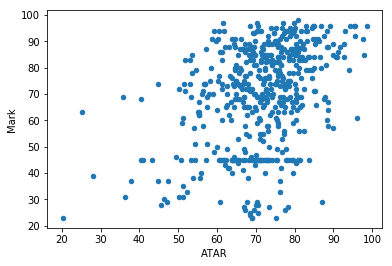

In [10]:
grades = pd.read_csv("files/grades.csv")
# remove zeros
grades = grades.drop(grades.index[(grades.Mark == 0) | (grades.ATAR == 0)])
grades.plot('ATAR', 'Mark', kind='scatter')

We can see from the plot that there isn't much of a relationship between these two variables. As ATAR increases, the range of values for Mark doesn't change very much.  

To quantify this we can look at the **covariance** or **correlation** between the two variables.  

**Covariance** - how the two variables vary together, larger values mean that the size of the mutual deviation from the mean is large. If two variables are totally unrelated, the covariance would be zero.

But the fact that covariance can be any value makes it hard to interpret:

In [52]:
grades.cov()

,ATAR,Mark
ATAR,122.931200,78.932811
Mark,78.932811,359.535302


**Correlation** is a normalised version of covariance, standardised to between -1 and 1.  

Much easier to interpret - a value of 1 (or -1) means a perfect relationship between the two variables.  The close to 1 the better the relationship.  

The correlation of Mark and ATAR is 0.37 which is very low, confirming that there is no real relationship between these variables.

In [54]:
grades.corr()

,ATAR,Mark
ATAR,1.000000,0.373856
Mark,0.373856,1.000000


Let's look at another dataset that shows a better correlation.  This is the [auto-mpg dataset](https://archive.ics.uci.edu/ml/datasets/Auto+MPG) from the UCI archive.

In [6]:
names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
autompg = pd.read_csv('files/auto-mpg.data', delim_whitespace=True, names=names)
autompg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


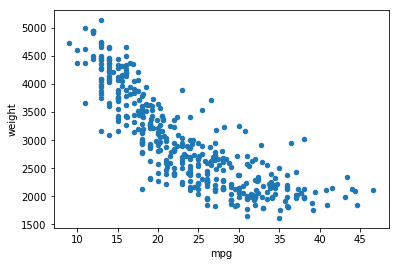

In [7]:
autompg.plot('mpg', 'weight', kind='scatter')

We can see from the plot an more obvious negative relationship between *mpg* and *weight* - heavier cars use more fuel. 

The correlation is -0.83 which is close to -1 and shows a high negative correlation.  

In [9]:
autompg.corr()

,mpg,cylinders,displacement,weight,acceleration,year,origin
mpg,1.000000,-0.775396,-0.804203,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.950721,0.896017,-0.505419,-0.348746,-0.562543
displacement,-0.804203,0.950721,1.000000,0.932824,-0.543684,-0.370164,-0.609409
weight,-0.831741,0.896017,0.932824,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.505419,-0.543684,-0.417457,1.000000,0.288137,0.205873
year,0.579267,-0.348746,-0.370164,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.562543,-0.609409,-0.581024,0.205873,0.180662,1.000000


## Hypothesis Testing

(Textbook Section 4.4)

In an experiment we might observe a difference in the outcome for the control and treatment groups - high ATAR students might get higher grades on average than low ATAR students for example.  This difference could be due to a real difference between these groups, or it could be just happening by chance.  We may have accidentally chosen some really good high ATAR students and some really poor low ATAR students.  How can we be sure of our conclusion?

Hypothesis testing is a method of measuring the liklihood that an observed difference occured by chance.

It can be used in cases where we have two samples from a population that we believe are different - because we gave them different medicines or because they differ by some factor we think is causally related to the outcome (older, smarter, richer). 

Define a **null hypothesis** that the populations are really the same.  Aim to **reject the null hypothesis** by showing that this could only happen with a very low probability.

One measure used is the *p-value* which is the probability that the observed difference could occur at random. I recommend you read the textbook section (4.4) which provides a nice explanation of this. The basic idea they describe is:

- from the overall population (the two groups pooled together), draw samples of size N
- compute the difference between the mean of this sample and the overall mean
- count how many times the difference is larger than the one we observe overall between the two groups

If we can find lots of cases where the sample we draw has a larger difference from the mean, then the difference we observe is likely to be just a random effect.   If it hardly ever happens, then the difference we observe might be a significant one. 

It is common to set a threshold of 5% for significance.  If the p value is less than 0.05 we say that the observed difference is unlikely to occur at random and so is likely to be due to a real effect.  We **reject the null hypothesis** that these distributions are the same.

